# 1.基本信息
- 项目文档地址：
    - https://python.langchain.com/docs/tutorials/classification/
- DeepSeek在LangChain中的集成文档地址：
    - https://python.langchain.com/api_reference/deepseek/chat_models/langchain_deepseek.chat_models.ChatDeepSeek.html

# 2.为文本生成标签-Tagging
- Tagging是什么？
    - 在 LangChain 中，Tagging（标注） 主要用于对文档或文本数据进行分类，以便更有效地检索、筛选或路由信息。它可以用于以下场景：
        - 文本分类：将文档按情感、语言、风格、主题等类别进行标注，方便后续查询和分析。
        - 增强检索：结合向量数据库，基于标签（如政治倾向、行业类别）进行更精准的检索，而不仅仅依赖文本相似度。
        - 过滤和排序：在 RAG（检索增强生成）系统中，使用标签对检索出的文档进行过滤，提高答案的相关性。
        - 元数据存储：LangChain 允许在 Document 对象中存储 metadata，其中可以包含标签信息，方便在查询时利用。
    - 如果你在 LangChain 中使用 标签（tagging），通常会结合 LLM、向量数据库（如 FAISS） 或 关键词提取工具 进行自动分类。

- 标注（Tagging）指的是用类别对文档进行标记，例如：
    - 情感
    - 语言
    - 风格（正式、非正式）
    - 涉及的主题
    - 政治倾向
- 图解
    - 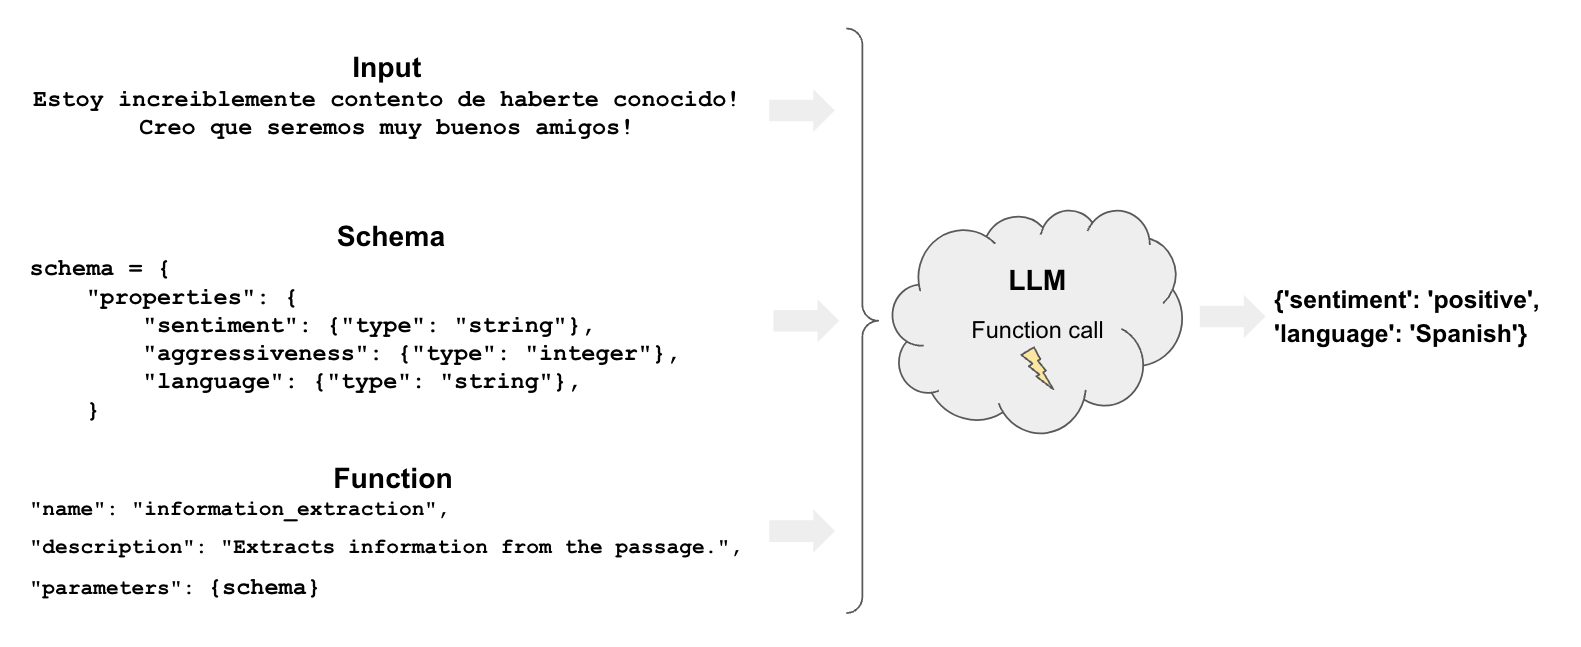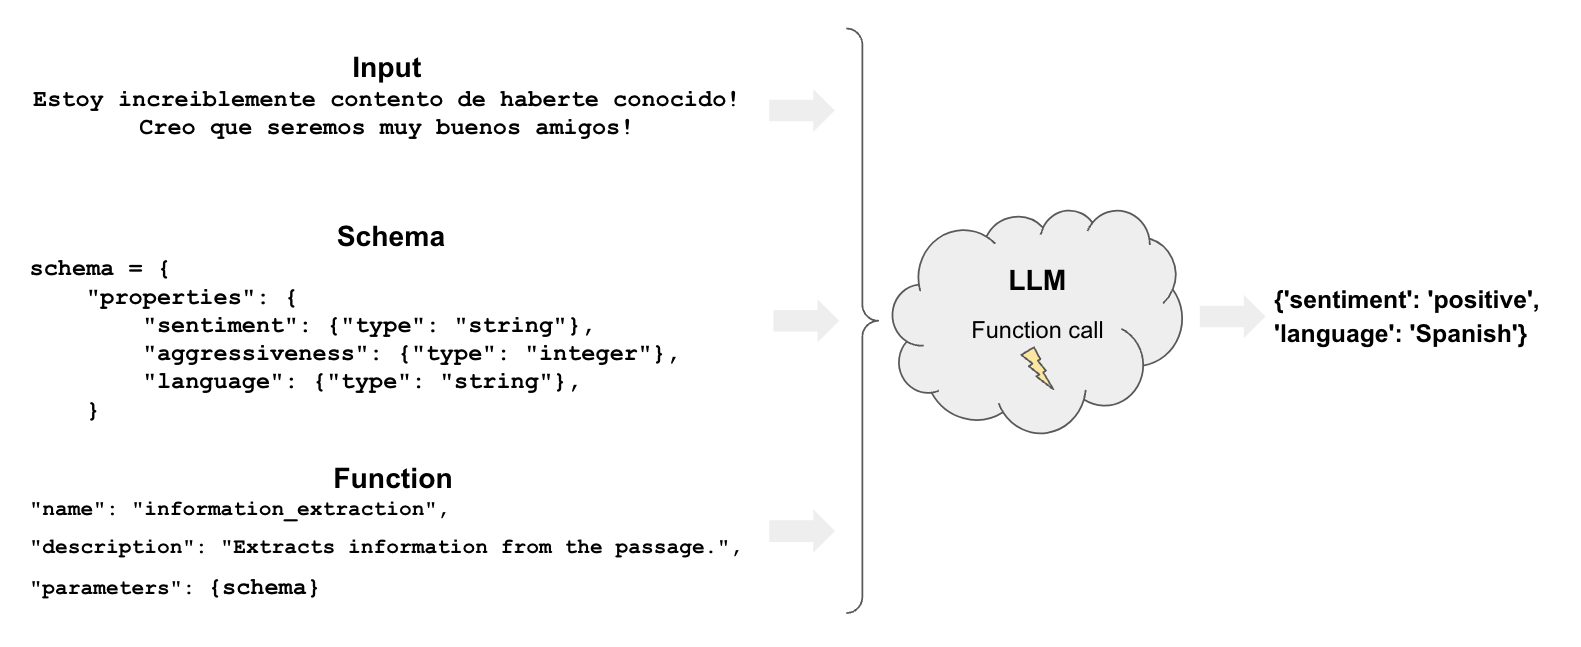
    - 图解地址：https://python.langchain.com/assets/images/tagging-93990e95451d92b715c2b47066384224.png
    - Schema ： 定义数据结构，确保输入正确。
        

# 3.Overview
- Tagging有一些组件：
    - function：类似抽取，tagging使用function来确定模型如何归类文档
    - schema： 定义了我们想要如何为标记文档

## 3.1快速开始 - 连接DeepSeek
- 让我们来看看一个直接的案例，如何使用Deepseek的tool calling在LangChain中对文本进行标签化。我们将使用由deepseek支持的with_structured_output方法。

- 静默安装langchain-core  
    - pip install --upgrade --quiet langchain-core

- 静默安装langchain-deepseek接口集成
    - pip install -qU "langchain-deepseek"

In [4]:
import getpass
import os  
# 前置需要进入deepseek官网注册并生成API_KEY，记得保存好，否则丢失后需要重新生成。
# 这一行检查程序是否已经有 Deepseek API 密钥。如果没有，就需要用户手动输入。
if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")
    
# 配置接口参数，创建语言模型的实例
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(
    model="deepseek-chat",  # 指定使用的模型
    temperature=0,  # 控制生成文本的随机性
    max_tokens=None,  # 生成的最大 token 数限制
    timeout=None,  # 请求超时时间
    max_retries=2, # 请求失败时的最大重试次数
    # other params...
)

Enter your DeepSeek API key:  ········


- 配置好Deepseek的交互信息后，为我们的schema指定一个Pydantic模型，并为其属性定义预期类型。
- 什么事Pydantic？ 
    - Pydantic 是一个用于数据验证和数据解析的 Python 库，它基于 Python 的类型注解来定义数据模型，并自动执行类型检查和数据转换。它通常用于 FastAPI、Django、Flask 等 Web 框架，也适用于任何需要严格数据结构的 Python 项目。

## 3.2 构建tagging输出模版

In [12]:
# 用于构建对话提示模板的类。
from langchain_core.prompts import ChatPromptTemplate
# 来自 Pydantic，用于定义数据模型和字段描述。
from pydantic import BaseModel, Field
# 用于与 DeepSeek 模型交互的类。
from langchain_deepseek import ChatDeepSeek

# 这段代码创建了一个 ChatPromptTemplate 实例，定义了一个模板，用于指导模型从提供的文本段落中提取所需的信息。
# 模板中包含一个占位符 {input}，将在实际使用时被具体的输入文本替换。
tagging_prompt = ChatPromptTemplate.from_template(
    """
Extract the desired information from the following passage.

Only extract the properties mentioned in the 'Classification' function.

Passage:
{input}
"""
)

# 使用 Pydantic 的 BaseModel 定义了一个名为 Classification 的数据模型，包含三个字段
# 没学过Python的同学这里需要去学一下python的类和类的继承，还要学一下Basemodels的特性，这块才能看懂
class Classification(BaseModel):
    sentiment: str = Field(description="The sentiment of the text")
    aggressiveness: int = Field(
        description="How aggressive the text is on a scale from 1 to 10"
    )
    language: str = Field(description="The language the text is written in")
    

# LLM
# temperature 是控制语言模型输出随机性的参数。

# temperature=0 表示完全确定性输出，适合需要精确、稳定的任务（比如你的结构化分类任务）。
llm = ChatDeepSeek(temperature=0, model="deepseek-chat").with_structured_output(
    Classification
)

# 总体的思路是定义提示词模版，设置好文本输入占用符，方便后续调用
# 定义数据输出格式，及我们想要给输入的文本打哪几个标签，如何归类
# 最后创建一个大模型实例，这个实例定义好了我们要用的模型核心及相应的输出参数，给到了数据归类的方法以及数据输出的格式
# 下一步就是输入文本，调用我们创建好的实例来对文本进行判断标记


- **temperature 是什么？**
    - 在语言模型（LLM）中，temperature 是一个控制输出随机性和创造性的超参数。具体来说：
    - 定义：
        - temperature 是一个浮点数，通常在 0 到 1 之间（但有些模型允许更大的值，比如 2）。
        - 它影响模型生成文本时的概率分布。
    - 作用：
        - 语言模型生成文本时，会根据输入预测下一个词的概率分布（比如“今天天气很好，下一个词可能是‘所以’、‘但是’、‘真棒’等”）。
        - temperature 控制这个概率分布的“平滑程度”：
            - 低 temperature（接近 0）：模型更倾向于选择概率最高的词，输出更确定、更保守。
            - 高 temperature（大于 1）：模型会更多地考虑低概率的词，输出更随机、更具创造性。
    - 直观理解：
        - 想象你在掷骰子：
            - temperature=0：每次都只选最可能的结果（比如总是选“6”）。
            - temperature=1：按正常概率分布选（每个数字的机会都合理）。
            - temperature=2：连小概率事件（比如“1”）都有更大机会被选中，变得更随机。
- **aggressiveness属性解释**
    - 在您提供的 Classification 数据模型中，aggressiveness 属性用于表示文本的攻击性程度。该属性的值为整数，范围从 1 到 10，数值越大表示文本越具攻击性。这种评分机制有助于量化文本的攻击性，以便在自然语言处理任务中进行分析和处理。
    - 示例：
        - aggressiveness = 1：表示文本几乎没有攻击性，内容温和。
        - aggressiveness = 5：表示文本具有中等程度的攻击性。
        - aggressiveness = 10：表示文本极具攻击性，内容可能包含强烈的敌意或冒犯性语言。
    - 通过在数据模型中明确定义 aggressiveness 属性，可以在处理和分析文本时更精确地评估其攻击性程度，从而实现更精细的控制和分类。

In [15]:
inp = "Estoy increiblemente contento de haberte conocido! Creo que seremos muy buenos amigos!"
prompt = tagging_prompt.invoke({"input":inp})
response = llm.invoke(prompt)

response

Classification(sentiment='positive', aggressiveness=1, language='es')

- 如果我们想要字典化的输出，我们可以使用.model_dump()方法

In [18]:
inp = "Estoy increiblemente contento de haberte conocido! Creo que seremos muy buenos amigos!"
prompt = tagging_prompt.invoke({"input":inp})
response = llm.invoke(prompt)

response.model_dump()

{'sentiment': 'positive', 'aggressiveness': 1, 'language': 'Spanish'}

- 结果可能有所不同，例如，我们可能会得到用不同语言表示的情感（如“positive”、“enojado”等）。
- 下一个部分，我们会学习如何控制这些结果

## 精细控制 - Finer control

- 精心定义模式可以让我们更好的控制模型
- 例如，我们可以定义
    - 每个属性可能的值
    - 定义属性的描述信息，让大模型能够更好的理解
    - 返回要求的属性结果  
- 这里我们重构我们的Pydantic模型，用枚举的方式控制我们之前提到的每一个方面。

In [19]:
class Classification(BaseModel):
    # 加 ... 是明确告诉 Pydantic，“这个字段是必填的，不能省略”，而 enum 只是限制字段值的范围。
    sentiment: str = Field(..., enum=["happy","neutral","sad"])
    aggressiveness: int = Field(
        ...,
        description="describe how aggressive the statement is, the gigher the number the more aggressive",
        enum=[1,2,3,4,5],
    )
    language: str = Field(
        ...,enum=["spanish","english","french","german","italian"]
    )

In [21]:
tagging_prompt = ChatPromptTemplate.from_template(
    """
Extract the desired indormation from the following passage.

Only extract the properties mentioned in the 'Classification' function.

Passage:
{input}
"""
)

llm = ChatDeepSeek(temperature=0, model="deepseek-chat").with_structured_output(
    Classification
)


In [22]:
# 在上面的模式中做了限制之后，答案会被限制在我们期望的范围内
inp = "Estoy increiblemente contento de haberte conocido! Creo que seremos muy buenos amigos!"
prompt = tagging_prompt.invoke({"input": inp})
llm.invoke(prompt)

Classification(sentiment='happy', aggressiveness=1, language='spanish')

In [23]:
# 例子2
inp = "Weather is ok here, I can go outsife without much more than a coat"
prompt = tagging_prompt.invoke({"input": inp})
llm.invoke(prompt)

Classification(sentiment='neutral', aggressiveness=1, language='english')